# Minplus algebra experiment

This code attempts to learn the 16D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False, "font.size": 16})

sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions$(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Convex functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 16

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 30000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 514.2996215820312
iteration 0 loss 221.13345336914062


iteration 5000 loss 0.03852434083819389


iteration 10000 loss 0.015791140496730804


iteration 15000 loss 0.021127445623278618


iteration 20000 loss 0.006744892802089453


iteration 25000 loss 0.004959931131452322


iteration 30000 loss 0.004128837492316961


iteration 35000 loss 0.0036547821946442127


iteration 40000 loss 0.002946065738797188


iteration 45000 loss 0.0025577356573194265


iteration 50000 loss 0.002271335804834962


iteration 55000 loss 0.002155805006623268


iteration 60000 loss 0.001962896203622222


iteration 65000 loss 0.001812001341022551


iteration 70000 loss 0.001711810939013958


iteration 75000 loss 0.0018138005398213863


iteration 80000 loss 0.0015567683149129152


iteration 85000 loss 0.0015402620192617178


iteration 90000 loss 0.0015161061892285943


iteration 95000 loss 0.005093373823910952


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0013865239452570677


iteration 105000 loss 0.0011385063407942653


iteration 110000 loss 0.0009866795735433698


iteration 115000 loss 0.0009004842140711844


iteration 120000 loss 0.0008390126749873161


iteration 125000 loss 0.0007911739521659911


iteration 130000 loss 0.0007505317917093635


iteration 135000 loss 0.0007153456681407988


iteration 140000 loss 0.0007729439530521631


iteration 145000 loss 0.0007955202017910779


iteration 150000 loss 0.0009115951252169907


iteration 155000 loss 0.000608681992162019


iteration 160000 loss 0.0005876873037777841


iteration 165000 loss 0.00056844501523301


iteration 170000 loss 0.0005508349859155715


iteration 175000 loss 0.0005341330543160439


iteration 180000 loss 0.00051877397345379


iteration 185000 loss 0.000504508032463491


iteration 190000 loss 0.0004958443460054696


iteration 195000 loss 0.00047802814515307546


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0004658884136006236


iteration 205000 loss 0.0004600644751917571


iteration 210000 loss 0.0004496391338761896


iteration 215000 loss 0.00043992538121528924


iteration 220000 loss 0.0004305104084778577


iteration 225000 loss 0.0004213419742882252


iteration 230000 loss 0.0004127097490709275


iteration 235000 loss 0.00040459766751155257


iteration 240000 loss 0.00039679574547335505


iteration 245000 loss 0.0003891455999109894


iteration 250000 loss 0.00038185686571523547


iteration 255000 loss 0.00037484854692593217


iteration 260000 loss 0.00036824215203523636


iteration 265000 loss 0.0003617292386479676


iteration 270000 loss 0.00035561234108172357


iteration 275000 loss 0.00034970065462403


iteration 280000 loss 0.00034387665800750256


iteration 285000 loss 0.0003383125877007842


iteration 290000 loss 0.00033293559681624174


iteration 295000 loss 0.00032771137193776667


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0003231882001273334


iteration 305000 loss 0.00031998296617530286


iteration 310000 loss 0.00031483350903727114


iteration 315000 loss 0.00030990189407020807


iteration 320000 loss 0.0003050886152777821


iteration 325000 loss 0.0003004104655701667


iteration 330000 loss 0.0002958689583465457


iteration 335000 loss 0.0002913123753387481


iteration 340000 loss 0.00028701897826977074


iteration 345000 loss 0.0002828552678693086


iteration 350000 loss 0.00027894775848835707


iteration 355000 loss 0.0002751215943135321


iteration 360000 loss 0.0002713121357373893


iteration 365000 loss 0.00026757820160128176


iteration 370000 loss 0.00026404650998301804


iteration 375000 loss 0.00026063626864925027


iteration 380000 loss 0.00025733758229762316


iteration 385000 loss 0.0002540612476877868


iteration 390000 loss 0.0002508304896764457


iteration 395000 loss 0.00024774286430329084


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.00024466999457217753


iteration 405000 loss 0.0002435665373923257


iteration 410000 loss 0.0002406534185865894


iteration 415000 loss 0.00023779465118423104


iteration 420000 loss 0.00023501136456616223


iteration 425000 loss 0.0002323035296285525


iteration 430000 loss 0.00022965052630752325


iteration 435000 loss 0.00022705303854309022


iteration 440000 loss 0.00022451308905147016


iteration 445000 loss 0.0002220229507656768


iteration 450000 loss 0.00021957207354716957


iteration 455000 loss 0.00021717351046390831


iteration 460000 loss 0.00021481896692421287


iteration 465000 loss 0.00021250751160550863


iteration 470000 loss 0.00021023712179157883


iteration 475000 loss 0.00020800869970116764


iteration 480000 loss 0.00020582415163516998


iteration 485000 loss 0.00020368292462080717


iteration 490000 loss 0.00020158231200184673


iteration 495000 loss 0.00019952173170167953


L2 loss -- Plot

loss 23.013038635253906


loss -77.58943939208984


loss -152.87606811523438


loss -214.78939819335938


loss -266.1566162109375


loss -309.163818359375


loss -345.2841796875


loss -375.5392761230469


loss -400.71514892578125


loss -421.4680480957031


loss -438.37103271484375


loss -451.9559326171875


loss -462.7286376953125


loss -471.1253662109375


loss -477.50286865234375


loss -482.177490234375


loss -485.44921875


loss -487.61260986328125


loss -488.961181640625


loss -489.7589111328125


loss -490.20709228515625


loss -490.4421691894531


loss -490.5531921386719


loss -490.59808349609375


loss -490.6127014160156


loss -490.61627197265625


loss -490.6168518066406


loss -490.61688232421875


loss -490.61688232421875


loss -490.61688232421875


loss -490.6169128417969


loss -490.61688232421875


loss -490.6169128417969


loss -490.61688232421875


loss -490.61688232421875


loss -490.61688232421875


loss -490.61688232421875


loss -490.6169128417969


loss -490.61688232421875


loss -490.61688232421875


final mse:  2.3537469195922256e-10
max, min: 7.034377 -8.744788
loss 23.013038635253906


loss -83.65438842773438


loss -162.53636169433594


loss -229.232666015625


loss -285.6938171386719


loss -333.4769592285156


loss -373.85064697265625


loss -407.8213195800781


loss -436.230224609375


loss -459.7908935546875


loss -479.0703125


loss -494.5475158691406


loss -506.70501708984375


loss -516.0390625


loss -523.0233154296875


loss -528.0879516601562


loss -531.6152954101562


loss -533.946044921875


loss -535.3845825195312


loss -536.1973266601562


loss -536.607177734375


loss -536.785400390625


loss -536.849365234375


loss -536.8672485351562


loss -536.8709106445312


loss -536.8714599609375


loss -536.8714599609375


loss -536.8714599609375


loss -536.8714599609375


loss -536.8714599609375


loss -536.8714599609375


loss -536.8714599609375


loss -536.8714599609375


loss -536.8714599609375


loss -536.8714599609375


loss -536.8714599609375


loss -536.8714599609375


loss -536.8714599609375


loss -536.8714599609375


loss -536.8714599609375


final mse:  2.060075582344112e-10
max, min: 7.9920416 -8.296064


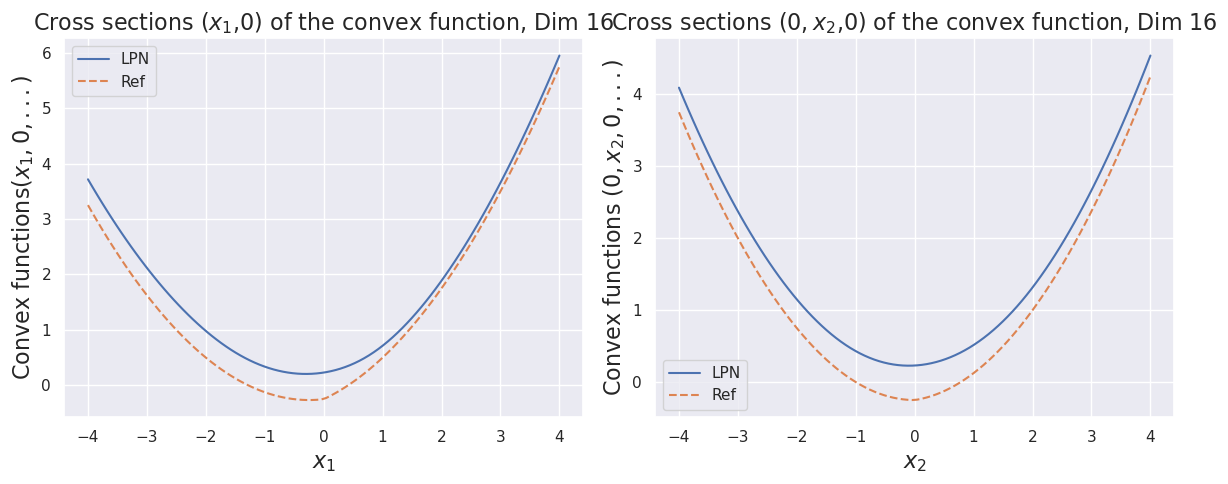

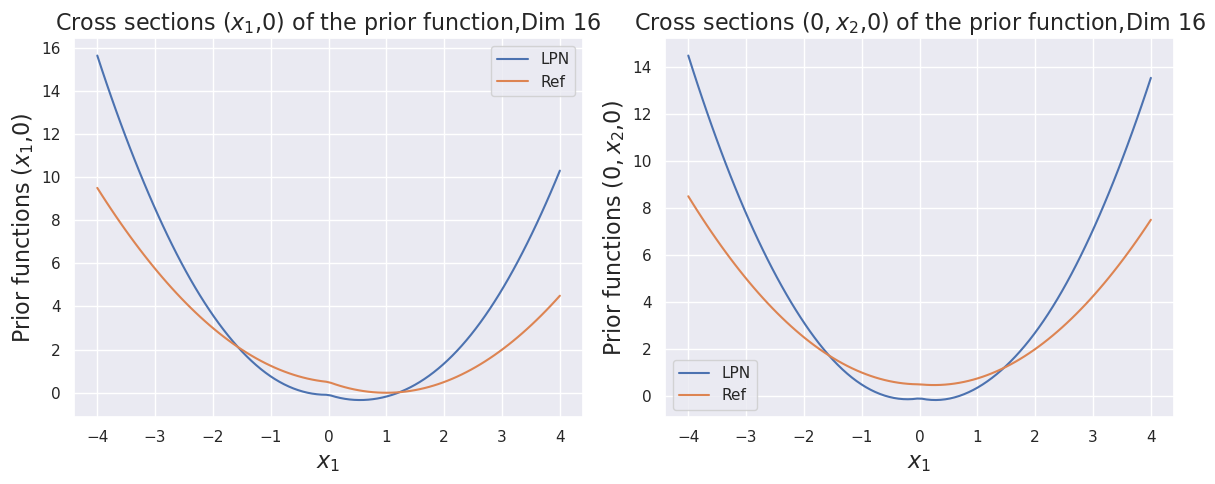

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

iteration 0 loss 472.12933349609375
iteration 0 loss 11.225911140441895


iteration 5000 loss 0.03016975149512291


iteration 10000 loss 0.018232544884085655


iteration 15000 loss 0.01248970441520214


iteration 20000 loss 0.009560519829392433


iteration 25000 loss 0.007506777066737413


iteration 30000 loss 0.0062988512217998505


iteration 35000 loss 0.005280116107314825


iteration 40000 loss 0.004356030374765396


iteration 45000 loss 0.0037281932309269905


iteration 50000 loss 0.1237449198961258


iteration 55000 loss 0.0030265836976468563


iteration 60000 loss 0.0029774473514407873


iteration 65000 loss 0.002589995041489601


iteration 70000 loss 0.0024579111486673355


iteration 75000 loss 0.0025480962358415127


iteration 80000 loss 0.0021965636406093836


iteration 85000 loss 0.0020929197780787945


iteration 90000 loss 0.0021190205588936806


iteration 95000 loss 0.0019962280057370663


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.001970994984731078


iteration 105000 loss 0.0016591021558269858


iteration 110000 loss 0.0014699363382533193


iteration 115000 loss 0.0013553014723584056


iteration 120000 loss 0.0012711990857496858


iteration 125000 loss 0.005825266242027283


iteration 130000 loss 0.0011524800211191177


iteration 135000 loss 0.0011039507808163762


iteration 140000 loss 0.0010596587089821696


iteration 145000 loss 0.0010233205975964665


iteration 150000 loss 0.0009895330294966698


iteration 155000 loss 0.0009581047343090177


iteration 160000 loss 0.0009291088208556175


iteration 165000 loss 0.0009019634453579783


iteration 170000 loss 0.000878092716448009


iteration 175000 loss 0.0008550937054678798


iteration 180000 loss 0.0008341879583895206


iteration 185000 loss 0.0008135121315717697


iteration 190000 loss 0.0007949285209178925


iteration 195000 loss 0.0007756630075164139


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0007591898902319372


iteration 205000 loss 0.0007492899894714355


iteration 210000 loss 0.0007334987749345601


iteration 215000 loss 0.0007178873638622463


iteration 220000 loss 0.000703204539604485


iteration 225000 loss 0.0006897650309838355


iteration 230000 loss 0.0006758063100278378


iteration 235000 loss 0.0006630812422372401


iteration 240000 loss 0.000651954032946378


iteration 245000 loss 0.000639198930002749


iteration 250000 loss 0.0006281213136389852


iteration 255000 loss 0.0006168472464196384


iteration 260000 loss 0.0006070018280297518


iteration 265000 loss 0.0008257791050709784


iteration 270000 loss 0.0005871999310329556


iteration 275000 loss 0.0005777903716079891


iteration 280000 loss 0.0005688013625331223


iteration 285000 loss 0.0005604660836979747


iteration 290000 loss 0.0005520455888472497


iteration 295000 loss 0.0005440551904030144


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.000536637264303863


iteration 305000 loss 0.0005342362564988434


iteration 310000 loss 0.0005253373528830707


iteration 315000 loss 0.0005171730299480259


iteration 320000 loss 0.0005090080667287111


iteration 325000 loss 0.0005012833862565458


iteration 330000 loss 0.0004939137143082917


iteration 335000 loss 0.0004863744543399662


iteration 340000 loss 0.00047933319001458585


iteration 345000 loss 0.00047294379328377545


iteration 350000 loss 0.00046601248322986066


iteration 355000 loss 0.0004600107786245644


iteration 360000 loss 0.0004534597392193973


iteration 365000 loss 0.0004476302128750831


iteration 370000 loss 0.0004418854077812284


iteration 375000 loss 0.00043606958934105933


iteration 380000 loss 0.00043052530963905156


iteration 385000 loss 0.0004252253856975585


iteration 390000 loss 0.00042008032323792577


iteration 395000 loss 0.00041503619286231697


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.00041004360537044704


iteration 405000 loss 0.0004077196354046464


iteration 410000 loss 0.0004035472229588777


iteration 415000 loss 0.0003994904109276831


iteration 420000 loss 0.0003955307765863836


iteration 425000 loss 0.00039165077032521367


iteration 430000 loss 0.0003878459392581135


iteration 435000 loss 0.000384108949219808


iteration 440000 loss 0.00038043720996938646


iteration 445000 loss 0.00037682868423871696


iteration 450000 loss 0.0003732825571205467


iteration 455000 loss 0.0003697940846905112


iteration 460000 loss 0.00036636475124396384


iteration 465000 loss 0.0003629921702668071


iteration 470000 loss 0.00035967095755040646


iteration 475000 loss 0.00035639730049297214


iteration 480000 loss 0.00035317495348863304


iteration 485000 loss 0.00035000211209990084


iteration 490000 loss 0.0003468765935394913


iteration 495000 loss 0.0003437971754465252


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


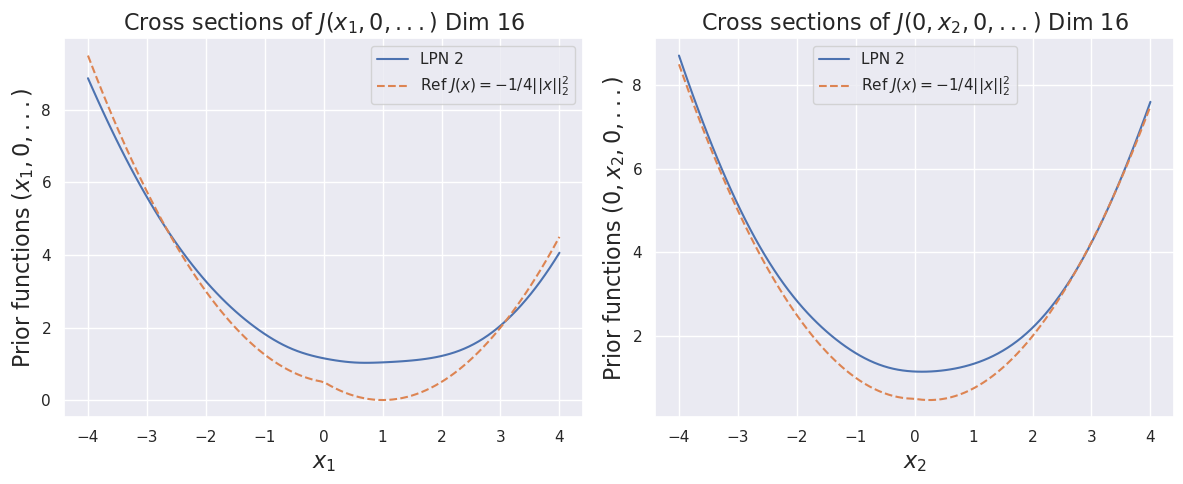

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)